**Import the libraries we'll use**

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

#plots
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

#tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras import metrics
from keras import utils

!pip install visualkeras
import visualkeras
from tensorflow.keras.utils import plot_model

%matplotlib inline

#Import CIFAR-10, CIFAR-100 Classification
from keras.datasets import cifar10, cifar100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Check Runtime Resources**

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 12 06:20:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    49W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


**CIFAR-10: Import and pre-process data**

In [4]:
# load training and testing datasets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()  # or cifar100.load_data()

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


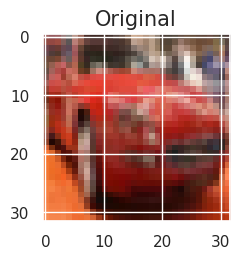

(50000, 32, 32, 3)


In [5]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)


fig = plt.figure(figsize=(14, 12))
image = x_train[5]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

plt.show()


print(x_train.shape)


In [6]:
# # Apply random shufflying to training examples.
# np.random.seed(0)
# indices = np.arange(x_train.shape[0])
# print(indices)
# shuffled_indices = np.random.permutation(indices)
# x_train = x_train[shuffled_indices]
# y_train = y_train[shuffled_indices]

**RESIZE to 64x64**

x_train shape:  (50000, 64, 64, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 64, 64, 3)
y_test shape:  (10000, 1)


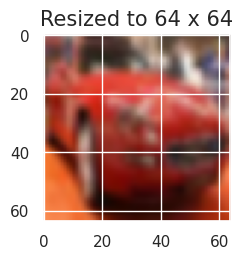

(50000, 64, 64, 3)


In [7]:
IMAGE_SIZE = (64,64)
x_train = tf.image.resize(x_train, size=IMAGE_SIZE)
x_test = tf.image.resize(x_test, size=IMAGE_SIZE)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)


fig = plt.figure(figsize=(14, 12))
image = x_train[5]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Resized to 64 x 64', size=15);
plt.show()
print(x_train.shape)

In [8]:
#Apply random shufflying to training examples.
# np.random.seed(0)
# indices = np.arange(x_train.shape[0])
# print(indices)
# shuffled_indices = np.random.permutation(indices)
# x_train = x_train[shuffled_indices]
# y_train = y_train[shuffled_indices]

# covert to RGB
x_train = x_train/255.0
x_test = x_test/255.0

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
# y_train = y_train.flatten()
# y_test = y_test.flatten()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#Apply random shufflying to training examples.
# np.random.seed(0)
# indices = np.arange(x_train.shape[0])
# print(indices)
# shuffled_indices = np.random.permutation(indices)
# x_train = x_train[shuffled_indices]
# y_train = y_train[shuffled_indices]

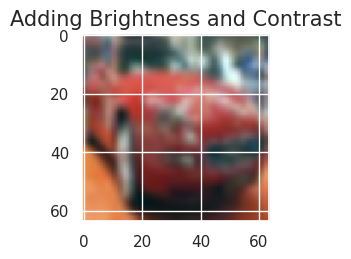

(50000, 64, 64, 3)


In [9]:
CONTRAST_FACTOR = 2
DELTA = 0.3
# adjust brightness
x_train_augm = tf.image.adjust_brightness(x_train, delta=DELTA)

# adjust contrast
x_train_augm = tf.image.adjust_contrast(x_train, contrast_factor=CONTRAST_FACTOR)

#####Plotting image after adjusting brightness and contrast ######
fig = plt.figure(figsize=(14, 12))
image = x_train_augm[5]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Adding Brightness and Contrast', size=15);
plt.show()
print(x_train.shape)
##############################################################

# random flip
x_train_augm = tf.image.random_flip_left_right(x_train_augm)

In [10]:
 # concatenate original X_train and augmented X_train data
x_train = tf.concat([x_train, x_train_augm],axis=0)

# concatenate y_train (note the label is preserved)
y_train_augm = y_train
y_train = tf.concat([y_train, y_train_augm],axis=0)

In [11]:
# shuffle X_train and y_train, i.e., shuffle two tensors in the same order
shuffle = tf.random.shuffle(tf.range(tf.shape(x_train)[0], dtype=tf.int32))
X_train = tf.gather(x_train, shuffle)
y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

###NOTE: FINAL TRAINING DATA SET IS STORED IN VARIABLE X_TRAIN

**Build CNN Model 3 With Batch Normalization**

In [12]:
def build_cnn_model_3(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.1):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()

  model.add(keras.layers.Conv2D(filters = 64, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())  
  model.add(keras.layers.Conv2D(filters = 64, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size = (2,2)))
  model.add(tf.keras.layers.Dropout(rate=0.4)) # adjust dropout layer

  model.add(keras.layers.Conv2D(filters = 128, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())  
  model.add(keras.layers.Conv2D(filters = 128, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size = (2,2)))
  model.add(tf.keras.layers.Dropout(rate=0.4)) # adjust dropout layer

  model.add(keras.layers.Conv2D(filters = 256, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())  
  model.add(keras.layers.Conv2D(filters = 256, kernel_size=(5,5), strides = (1,1), input_shape = (64,64,3), activation=activation, padding='same'))
  model.add(BatchNormalization())
  model.add(keras.layers.MaxPool2D(pool_size = (2,2)))
  model.add(tf.keras.layers.Dropout(rate=0.4)) # adjust dropout layer

  model.add(keras.layers.Flatten())
  for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=hidden_layer_size,
                                    activation = activation)) #use this for hidden layers
  
  model.add(tf.keras.layers.Dropout(rate=0.5)) # add dropout layer

  model.add(keras.layers.Dense(
      units=n_classes,
      activation="softmax")) #use "softmax" for active layers
  
  model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [13]:
model = build_cnn_model_3(len(label_names), learning_rate=0.01, hidden_layer_sizes=[1024, 1024])

history = model.fit(
  x = X_train,
  y = y_train,
  epochs=20, #can we train a bit longer
  batch_size=64,
  validation_split=0.1,
  verbose=1)

display(pd.DataFrame(history.history))
print(model.summary())

Epoch 1/20
1407/1407 [==============================] - 43s 21ms/step - loss: 1.7269 - accuracy: 0.4293 - val_loss: 1.5349 - val_accuracy: 0.5070
Epoch 2/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.9929 - accuracy: 0.6597 - val_loss: 0.9632 - val_accuracy: 0.6691
Epoch 3/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.7482 - accuracy: 0.7493 - val_loss: 0.7705 - val_accuracy: 0.7458
Epoch 4/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.5990 - accuracy: 0.8013 - val_loss: 0.5853 - val_accuracy: 0.8099
Epoch 5/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.4875 - accuracy: 0.8397 - val_loss: 0.5142 - val_accuracy: 0.8294
Epoch 6/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.4040 - accuracy: 0.8686 - val_loss: 0.4712 - val_accuracy: 0.8536
Epoch 7/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.3236 - accuracy: 0.8942 - val_loss: 0.5007 -

,loss,accuracy,val_loss,val_accuracy
0,1.726867,0.429278,1.534917,0.5070
1,0.992863,0.659656,0.963192,0.6691
2,0.748198,0.749256,0.770509,0.7458
3,0.599024,0.801333,0.585281,0.8099
4,0.487497,0.839711,0.514185,0.8294
5,0.403996,0.868622,0.471191,0.8536
6,0.323615,0.894200,0.500723,0.8615
7,0.273438,0.912711,0.428472,0.8778
8,0.228962,0.926789,0.446340,0.8837
9,0.199987,0.937756,0.468009,0.8778


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

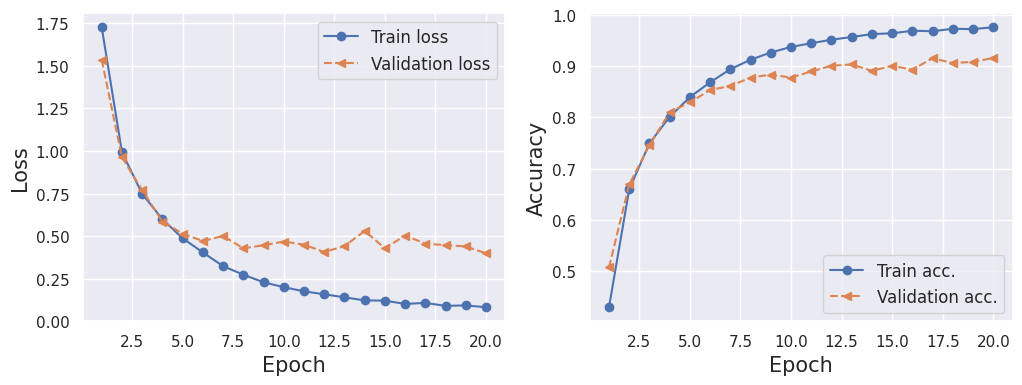

In [14]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [15]:
test_results = model.evaluate(x_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))


313/313 [==============================] - 2s 5ms/step - loss: 0.7460 - accuracy: 0.8480

Test Acc. 84.80%


In [16]:
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(x_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 1s 3ms/step
[3 8 8 ... 5 1 7]


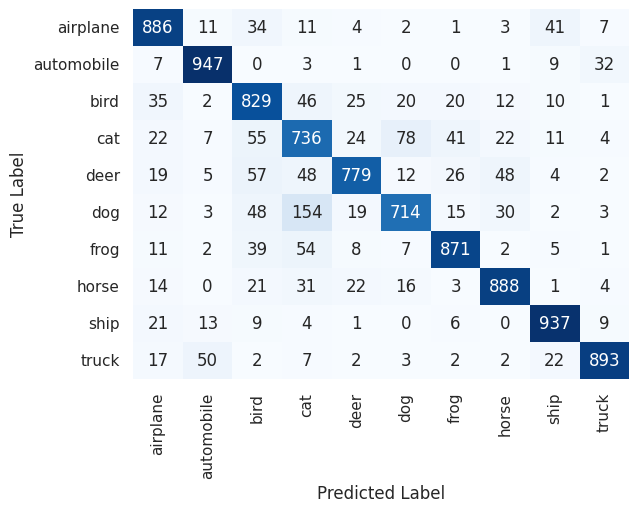

In [17]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

**Evaluate CNN Model Precision and Accuracy Metrics by Label**

In [18]:
# Calculate Precision: TP / (TP+FP) ~ divide the true positives for each label by the sum down the columns (axis=0) 
for i in range(10):
    print(label_names[i], "\t", confusion_matrix[(i,i)]/tf.reduce_sum(confusion_matrix,0)[i])

airplane 	 tf.Tensor(0.8486590038314177, shape=(), dtype=float64)
automobile 	 tf.Tensor(0.9105769230769231, shape=(), dtype=float64)
bird 	 tf.Tensor(0.7577696526508226, shape=(), dtype=float64)
cat 	 tf.Tensor(0.6727605118829981, shape=(), dtype=float64)
deer 	 tf.Tensor(0.880225988700565, shape=(), dtype=float64)
dog 	 tf.Tensor(0.8380281690140845, shape=(), dtype=float64)
frog 	 tf.Tensor(0.884263959390863, shape=(), dtype=float64)
horse 	 tf.Tensor(0.8809523809523809, shape=(), dtype=float64)
ship 	 tf.Tensor(0.8992322456813819, shape=(), dtype=float64)
truck 	 tf.Tensor(0.9341004184100419, shape=(), dtype=float64)
